In [1]:
import numpy as np
import bosonicplus

In [216]:
from bosonicplus.interferometers.symplectics import rotation
from bosonicplus.interferometers.ops import apply_symplectic
from bosonicplus.states.from_sf import prepare_cat_bosonic, prepare_gkp_bosonic
from bosonicplus.states.coherent import outer_coherent, eps_fock_coherent
from bosonicplus.states.wigner import get_wigner_coherent
from strawberryfields.backends.states import BaseBosonicState
from bosonicplus.plotting import plot_wigner_marginals
import matplotlib.pyplot as plt
from scipy.special import factorial
import strawberryfields as sf

from strawberryfields.ops import Kgate, Coherent, Catstate, Rgate
from time import time

#from bosonicplus.states.nongauss import 

In [159]:
class PureBosonicState:
    """Store a pure bosonic state as superposition of coherent states
    """
    def __init__(self, pure_data : tuple):
        """
        data = [alphas, coeffs]
        """
        self.pure_data = pure_data
        self.coeffs = pure_data[1]
        self.alphas = pure_data[0]
        self.num_alphas = len(self.alphas)

    def get_dm_form(self):
        means = []
        covs = np.eye(2)
        cs = self.coeffs
        weights = []

        for i in range(self.num_alphas):
            for j in range(self.num_alphas):
                
                mij, cov, cij = outer_coherent(self.alphas[i], self.alphas[j])
                weights.append(cs[i]*np.conjugate(cs[j])*cij)
                #weights[i,j] *= cij
                means.append(mij)
        
        self.data = np.array(means), covs, np.array(weights)/np.sum(weights)
        
    def get_fock_probs(self, cutoff = 10):
        ns = range(cutoff)
        ps = np.zeros(cutoff,dtype='complex')
        cs = self.coeffs
        a = self.alphas
        for n in ns: 
            
            for i in range(self.num_alphas):
                ps[n] += cs[i]* np.exp(-np.abs(a[i])**2/2) * a[i]**n/ np.sqrt(factorial(n))
                
        
        self.fock_probs = np.abs(ps)**2
        
def fock_coherent_pure(N, infid, eps = None):
    """Generate the pure state data for a Fock state N in the coherent state representation.
    
    Args:
        N (int): fock number
        infid (float): infidelity of approximation
        eps (float): coherent state amplitude, takes presidence over infid if specified.
        
    See Eq 28 of http://arxiv.org/abs/2305.17099 for expansion into coherent states.
    """
    
    alphas = []
    theta = 2*np.pi/(N+1)
    weights = []
    if not eps:
        eps = eps_fock_coherent(N, infid)
    
    for k in np.arange(N+1):

        alpha = eps * np.exp(1j * theta * k) 
        alphas.append(alpha)
        weights.append(np.exp(-theta*1j*N*k))

    #if N == 0:
     #   means = []
      #  means.append(np.array([0,0]))
        
            
    weights = np.array(weights)
    factor = np.sqrt(factorial(N))/(N+1) * np.exp(eps**2/2)/eps**N

    weights *= factor
    weights /= np.sqrt(np.sum(np.abs(weights)**2))
    
    return np.array(alphas), weights

def prepare_coherent(alpha):
    weights = np.array([1])
    means = np.array([np.array([alpha.real, alpha.imag])])
    covs = np.array([np.eye(2)])
    return BaseBosonicState([means, covs, weights], 1, 1)

In [160]:
def kerr_coeff(m, q): 
    """Eq. (13), (14) of https://journals.aps.org/pra/pdf/10.1103/PhysRevA.47.5024
    """
    ns = np.arange(m)
    
    if m % 2 == 1:
        return 1/m*np.exp(2*np.pi*1j*q/m * ns - 1j*np.pi/m*ns*(ns-1))
    elif m % 2 ==0: 
        return 1/m*np.exp(2*np.pi*1j*q/m * ns - 1j*np.pi/m*ns**2)

def kerr_exponents(m,q):
    ns = np.arange(m)
    
    if m % 2 == 1:
        return 2*np.pi*1j*q/m*ns - 1j*np.pi/m*ns*(ns-1)
    elif m % 2 ==0: 
        return 2*np.pi*1j*q/m*ns - 1j*np.pi/m*ns**2


def kerr_unitaries(m):
    """Eq. (16), (17) of https://journals.aps.org/pra/pdf/10.1103/PhysRevA.47.5024
    """
    qs = np.arange(m)
    
    weights = np.array([np.sum(kerr_coeff(m, q)) for q in qs])

    if m % 2 == 1: 
        thetas = 2*np.pi*qs/m
    elif m %2 == 0:
        thetas = 2*np.pi*qs/m + np.pi/m    
    return weights, thetas

def apply_kerr_gate(state, m):
    """
    state : PureBosonicState
    m : int
    """
    #kerr_weights = kerr_coeffs(m)
    kerr_weights, thetas =  kerr_unitaries(m)

    alphas, cs = state.pure_data
    print(alphas.shape, cs.shape)

    final_dim = len(kerr_weights) * len(cs)

    new_alphas = ((alphas[np.newaxis,:] * np.exp(-1j*thetas[:,np.newaxis]))).reshape([final_dim])

    new_cs = (cs[np.newaxis,:]*kerr_weights[:,np.newaxis]).reshape([final_dim])
    #new_weights /= np.sum(new_weights)
    print(new_alphas.shape, new_cs.shape)
    #norm = np.sqrt(np.sum(np.abs(new_cs)**2))

    out_state = PureBosonicState([new_alphas, new_cs])
    #print(np.sum(out_state.weights))
    return out_state


## Kerr interaction on a coherent state
$\hat{U}^{m}\ket{\alpha}$, where the unitary, $\hat{U}^{m}=e^{i\frac{\pi}{m}\hat{n}(\hat{n}+1)}$, can be written as a linear combination of rotations according to Eq. (10-11), (13-14) of https://journals.aps.org/pra/pdf/10.1103/PhysRevA.47.5024

In strawberryfields, the Kerr gate is $\hat{U}=e^{i\kappa \hat{n}^2}$, which is not exactly the same as the Kerr intreaction which is $\hat{H}=\kappa \hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a}$.

In [194]:
#Some general settings
alpha = np.sqrt(10)
x = np.linspace(-8,8,200)
m = 4

In [201]:
#Bosonicplus method
t0 = time()

#Initialise a coherent state
data = [np.array([alpha]),np.array([1])]
state = PureBosonicState(data)

kerr_state = apply_kerr_gate(state, m)

kerr_state.get_dm_form()
means, covs, weights = kerr_state.data
print('norm: ', np.sum(weights))
print(means.shape, covs.shape, weights.shape)

W_bp = get_wigner_coherent(kerr_state, x,x)

tf = time()


print(f'Total time to do kerr gate and obtain wigner with bosonicplus: {tf-t0} s')

(1,) (1,)
(3,) (3,)
norm:  (1+0j)
(9, 2) (2, 2) (9,)
Total time to do kerr gate and obtain wigner with bosonicplus: 0.035101890563964844 s


[4.53999298e-05 4.53999298e-04 2.26999649e-03 7.56665496e-03
 1.89166374e-02 3.78332748e-02 6.30554580e-02 9.00792257e-02
 1.12599032e-01 1.25110036e-01 1.25110036e-01 1.13736396e-01
 9.47803301e-02 7.29079462e-02 5.20771044e-02 3.47180696e-02
 2.16987935e-02 1.27639962e-02 7.09110899e-03 3.73216263e-03]


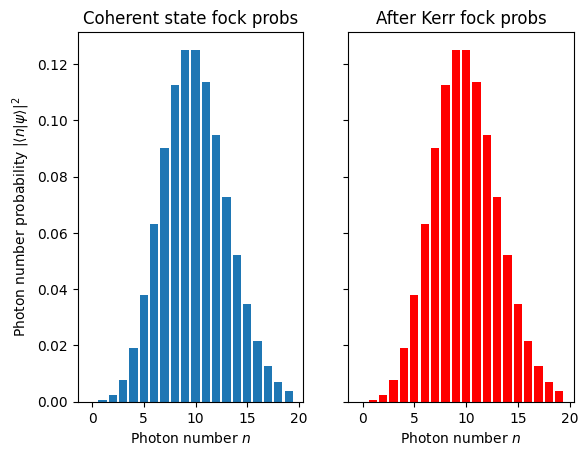

In [202]:
cutoff = 20
state.get_fock_probs(cutoff)
#state.fock_probs

kerr_state.get_fock_probs(cutoff)

print(kerr_state.fock_probs)
w = 1
fig, axes = plt.subplots(1,2,sharex=True,sharey=True)
axes[0].bar(np.arange(cutoff), state.fock_probs)
axes[0].set_title('Coherent state fock probs')
axes[0].set_ylabel(r'Photon number probability $|\langle n | \psi \rangle|^2$')
axes[0].set_xlabel(r'Photon number $n$')
axes[1].set_xlabel(r'Photon number $n$')
axes[1].bar(np.arange(cutoff), kerr_state.fock_probs,color='r')
axes[1].set_title('After Kerr fock probs')
plt.show()

In [208]:
#strawberryfields method
t0 = time()
eng = sf.Engine('fock', backend_options={"cutoff_dim": 20})
prog = sf.Program(1)

with prog.context as q:
    Coherent(alpha, np.pi/2) | q[0]
    Kgate(np.pi/m) | q[0]
result = eng.run(prog)
W_fock = result.state.wigner(0, x,x)

tf = time()

print(f'Total simulation time with strawberryfields {tf-t0}')

Total simulation time with strawberryfields 0.08572530746459961


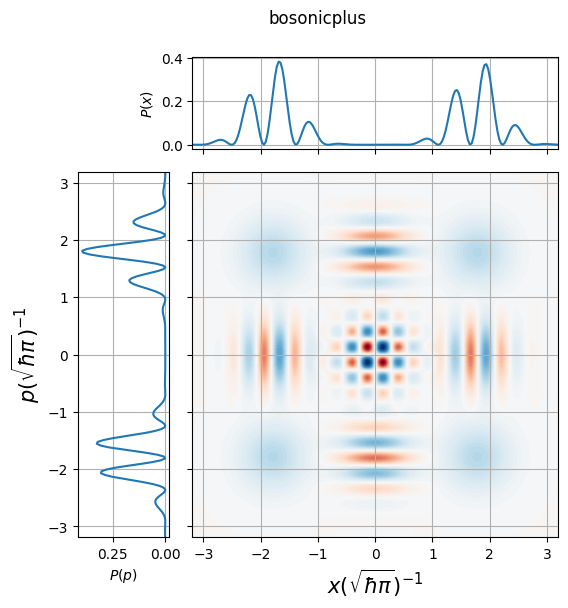

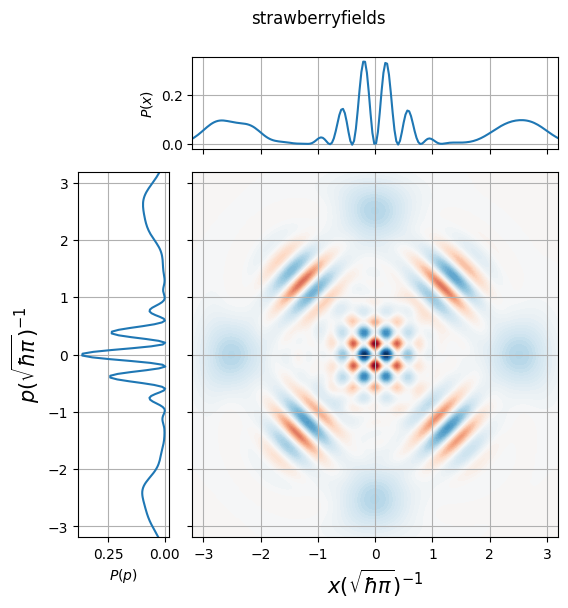

In [199]:
plot_wigner_marginals(W_bp,x,x,'bosonicplus')
plt.show()
plot_wigner_marginals(W_fock,x,x,'strawberryfields')
plt.show()

## Kerr interaction on cat states

(2,) (2,)
(16,) (16,)
norm:  (1+0j)
(256, 2) (2, 2) (256,)
0.3962368965148926


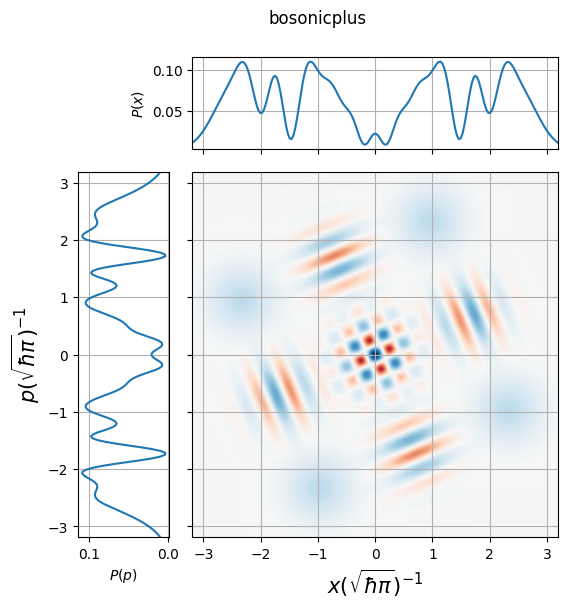

In [223]:
alpha = np.sqrt(10)
x = np.linspace(-8,8,200)
m = 8
t0 = time()
data = [np.array([alpha,-alpha]),1/np.sqrt(2)*np.array([1,1])]
state = PureBosonicState(data)

kerr_state = apply_kerr_gate(state, m)

kerr_state.get_dm_form()
means, covs, weights = kerr_state.data
print('norm: ', np.sum(weights))
print(means.shape, covs.shape, weights.shape)

W_bp = get_wigner_coherent(kerr_state, x,x)
tf = time()
print(tf-t0)
plot_wigner_marginals(W_bp,x,x,'bosonicplus')

plt.show()

[0.         0.000908   0.         0.01513331 0.         0.07566655
 0.         0.18015845 0.         0.25022007 0.         0.22747279
 0.         0.14581589 0.         0.06943614 0.         0.02552799
 0.         0.00746433]


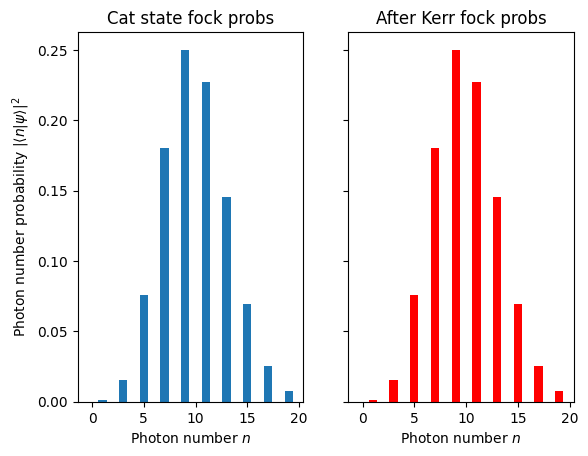

In [218]:
cutoff = 20
state.get_fock_probs(cutoff)
#state.fock_probs

kerr_state.get_fock_probs(cutoff)

print(kerr_state.fock_probs)
w = 1
fig, axes = plt.subplots(1,2,sharex=True,sharey=True)
axes[0].bar(np.arange(cutoff), state.fock_probs)
axes[0].set_title('Cat state fock probs')
axes[0].set_ylabel(r'Photon number probability $|\langle n | \psi \rangle|^2$')
axes[0].set_xlabel(r'Photon number $n$')
axes[1].set_xlabel(r'Photon number $n$')
axes[1].bar(np.arange(cutoff), kerr_state.fock_probs,color='r')
axes[1].set_title('After Kerr fock probs')
plt.show()

In [221]:
#strawberryfields method
t0 = time()
eng = sf.Engine('fock', backend_options={"cutoff_dim": 20})
prog = sf.Program(1)

with prog.context as q:
    Catstate(alpha, np.pi, 0) | q[0]
    Kgate(np.pi/m) | q[0]
    Rgate(-np.pi/m) | q[0]
result = eng.run(prog)
W_fock = result.state.wigner(0, x,x)

tf = time()

print(f'Total simulation time with strawberryfields {tf-t0}')

Total simulation time with strawberryfields 0.0959782600402832


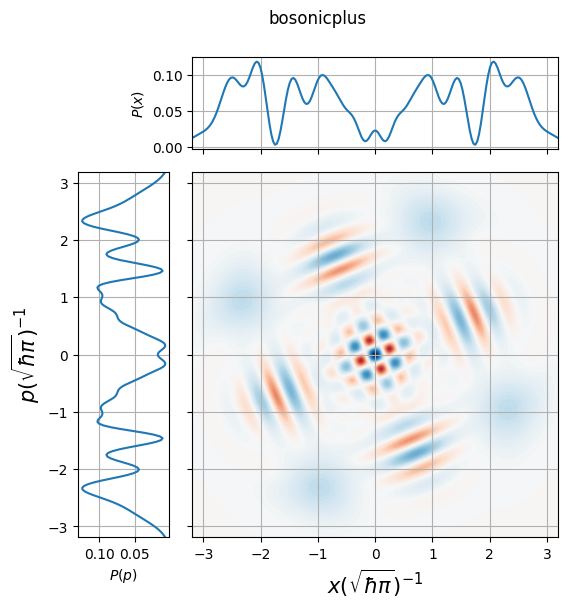

In [222]:
plot_wigner_marginals(W_fock,x,x,'bosonicplus')
plt.show()